In [1]:
#Mount Drive
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/Colab_Notebooks

Mounted at /gdrive
/gdrive/MyDrive/Colab_Notebooks


In [2]:
#GPU options
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Import Libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers


In [4]:
#Import Libraries for VGG_16
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn

In [5]:
#!unzip dataset.zip
#data_dir = 'training'

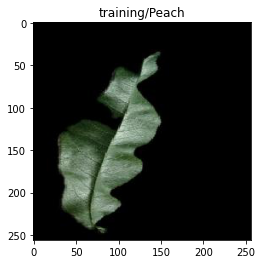

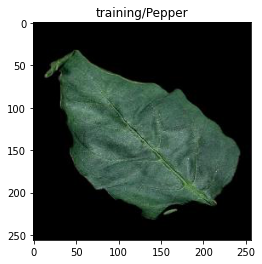

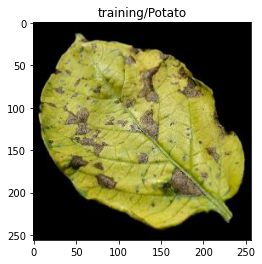

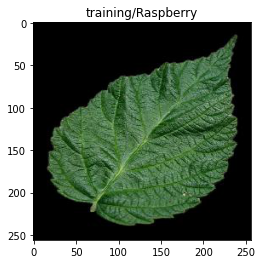

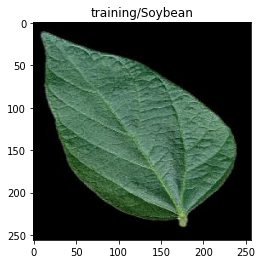

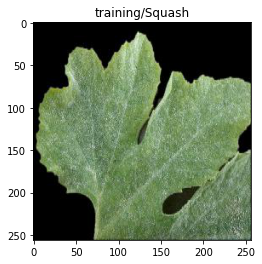

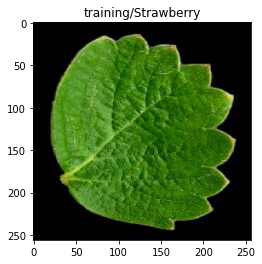

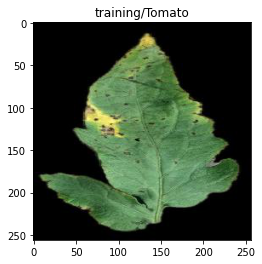

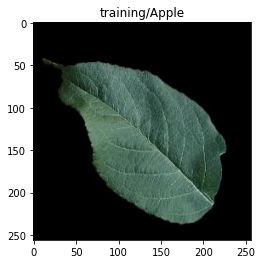

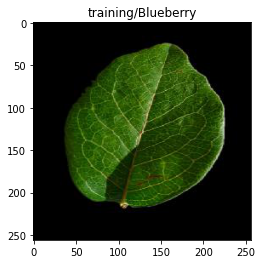

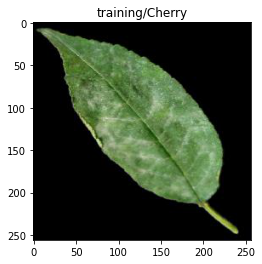

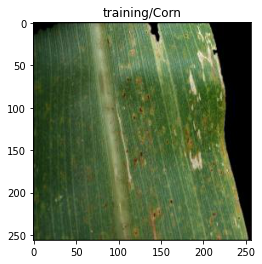

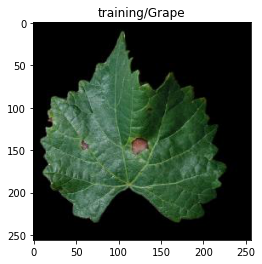

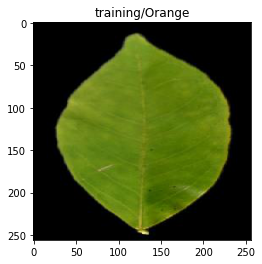

In [6]:
#Plot some images from our dataset
for subdir, dirs, files in os.walk('training'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

In [7]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Text(0.5, 1.0, 'Number of training images per category:')

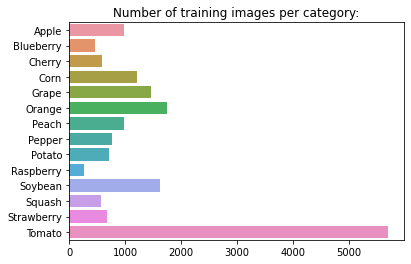

In [8]:
train_data_dir = "training"
category_names = sorted(os.listdir('training'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = 'training' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [9]:
#Define class_weights to be used in model.fit since the dataset is unbalanced
img_per_class={'Apple' : 988,
'Blueberry' : 467,
'Cherry' : 583,
'Corn' : 1206,
'Grape' : 1458,
'Orange' : 1748,
'Peach' : 977,
'Pepper' : 765,
'Potato' : 716,
'Raspberry' : 264,
'Soybean' : 1616,
'Squash' : 574,
'Strawberry' : 673,
'Tomato' : 5693}
img_tot = 17728
class_weight = {}
for i,x in enumerate(img_per_class):
  class_weight[i]=1/img_per_class[x]*img_tot/14

In [10]:
#Import VGG_16
img_height, img_width = 256,256
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [11]:
#Set all the layers as non-trainable except the last few ones for fine tuning
for layer in conv_base.layers[:-3]:
    layer.trainable = False
for layer in conv_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f90a57c1090> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90a8ab2e10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90a5785590> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f90a56ce510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90a468fc10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90a469a310> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f90a468fd90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90a469f3d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90a46a60d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90a469f8d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f90a462f550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [12]:
#Assemble the model
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(layers.Dense(200, kernel_initializer='uniform',activation='relu'))  
model.add(layers.Dense(nb_categories, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 200)               102600    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 14)                2814      
Total params: 14,860,302
Trainable params: 2,505,422
Non-trainable params: 12,354,880
_________________________________________________________________


In [13]:
# Number of images to load at each iteration
batch_size = 30

# Import our datasets
train_datagen = ImageDataGenerator(
    rotation_range=90, width_shift_range=40,
    brightness_range=[0.5, 1.5], shear_range=0.2, channel_shift_range=10.0,
    height_shift_range=40, zoom_range=0.3,
    fill_mode='reflect',
    horizontal_flip=True, vertical_flip=True, rescale=1./255.,
    validation_split=0.2
)


print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, img_width),
                                                    color_mode='rgb',
                                                    batch_size = batch_size, 
                                                    class_mode = "categorical",
                                                    seed=seed,
                                                    shuffle=True, 
                                                    subset='training')
print('Total number of images for "validation":')
val_generator = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = (img_height, img_width),
                                                 color_mode='rgb',
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 seed=seed,
                                                 shuffle=True,
                                                 subset='validation')

Total number of images for "training":
Found 14189 images belonging to 14 classes.
Total number of images for "validation":
Found 3539 images belonging to 14 classes.


In [14]:
#Set optimizer
opt = keras.optimizers.Adam(learning_rate=0.01)

#Set epochs
epochs = 10

#Compile the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
  exps_dir = 'VGG_16_Callbacks'
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [16]:
#Set callbacks
aug_callbacks = create_folders_and_callbacks(model_name='VGG_16')

In [17]:
tf.get_logger().setLevel('WARNING') #  if you want to suppress only INFOs

# Train the model
History = model.fit(
    x = train_generator,
    epochs = 15,
    validation_data = val_generator,
    callbacks = aug_callbacks,
    class_weight=class_weight
).history

Epoch 1/20
 14/473 [..............................] - ETA: 2:20:09 - loss: 2.7382 - accuracy: 0.1167

KeyboardInterrupt: ignored

In [ ]:
#Save the model
model.save('VGG_16_15epochs')

In [ ]:
#Val Train Loss
default_history=History
plt.figure(figsize=(15,5))
plt.plot(default_history['mse'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(default_history['val_mse'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 0.025)
plt.title('Mean Squared Error')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()